In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Local application/library specific imports
import importlib
import sys
import os
base_path = 'C:/Users/Henri/Emilie/Thesis'
sys.path.append(base_path + '/code')
import project_functions as pf
importlib.reload(pf) # Reloading the local module 

# Reloading the local module 
importlib.reload(pf)

<module 'project_functions' from 'C:\\Users/Henri/Emilie/Thesis/code\\project_functions.py'>

In [2]:
# Load data
df_test = pd.read_csv(base_path + f'/data/testZR_v3_63.csv')
df_test['R_mm_per_h'] = np.array(df_test['R'] * 60) # Convert mm/min to mm/h

# Remove nans
df_test = df_test.dropna(subset=['dBZ', 'R', 'Z'])

# Convert timestamp to datetime and remove low quality observations
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test[df_test['timestamp'].dt.minute % 10 == 0]

# Valid evaluation idx for evaluation
valid_idx = (df_test['R'] * 60 > 0) & (df_test['Z'] > 0)  & ~df_test['R'].isnull() & ~df_test['Z'].isnull()

# Set invalid rows to zero
df_test.loc[~valid_idx, ['R', 'Z']] = 0

### Compute predictions and average error metrics

In [3]:
# Parameters
A_est = [200, 219, 209, 196]
B_est = [1.6, 3.7, 3.6, 3.4]

A_est = [200, 218.60, 207.35, 190]
B_est = [1.6, 3.96, 3.86, 3.71]

# Compute rain rates
rain_rates = [pf.Z_to_R_marshall_palmer(df_test['Z'], A, B) for A, B in zip(A_est, B_est)]

In [4]:
# Compute error metrics only on valid idx
error_metrics = []
for R_pred in rain_rates:
    rmse = np.sqrt(mean_squared_error(df_test['R_mm_per_h'].loc[valid_idx], R_pred[valid_idx]))
    mae = mean_absolute_error(df_test['R_mm_per_h'].loc[valid_idx], R_pred[valid_idx])
    me = np.mean(R_pred[valid_idx] - df_test['R_mm_per_h'].loc[valid_idx])
    error_metrics.append((rmse, mae, me))

# Create a DataFrame for better visualization
error_df = pd.DataFrame(error_metrics, columns=['RMSE', 'MAE', 'ME'], index=[f'A={A}, B={B}' for A, B in zip(A_est, B_est)])

In [5]:
latex_table = tabulate(error_df, headers='keys', tablefmt='latex', showindex=True)
print(latex_table)

\begin{tabular}{lrrr}
\hline
                  &    RMSE &      MAE &        ME \\
\hline
 A=200, B=1.6     & 3.53867 & 1.35335  &  0.386718 \\
 A=218.6, B=3.96  & 2.76961 & 0.915941 & -0.554498 \\
 A=207.35, B=3.86 & 2.75444 & 0.911054 & -0.535349 \\
 A=190, B=3.71    & 2.72872 & 0.903781 & -0.501119 \\
\hline
\end{tabular}


## Error metrics for different intensities

In [6]:
# Define rain intensity bins
bins = [0.5, 2, 6, 10, 18, 30, np.inf]
labels = ['Weak rain\n(0.5-2 mm/h)', 'Moderate rain\n(2-6 mm/h)', 
          'Heavy rain\n(6-10 mm/h)', 'Very heavy rain\n(10-18 mm/h)', 'Shower\n(18-30 mm/h)', 'Cloudburst\n(>30 mm/h)']

# Bin the R_true values
df_test['rain_bin'] = pd.cut(df_test['R_mm_per_h'], bins=bins, labels=labels, right=False)

# Initialize a dictionary to store the error metrics
error_dict = {
    'Parameters': [],
    'Rain Bin': [],
    'RMSE': [],
    'MAE': [],
    'ME': []
}

# Calculate the total absolute error for each bin
for A, B in zip(A_est, B_est):
    df_test['R_pred_mm_per_h'] = pf.Z_to_R_marshall_palmer(df_test['Z'], A, B)
    for label in labels:
        bin_data = df_test[(df_test['rain_bin'] == label) & valid_idx]
        rmse = np.sqrt(mean_squared_error(bin_data['R_mm_per_h'], bin_data['R_pred_mm_per_h']))
        mae = mean_absolute_error(bin_data['R_mm_per_h'],  bin_data['R_pred_mm_per_h'])
        me = np.mean(bin_data['R_pred_mm_per_h'] - bin_data['R_mm_per_h'])
        error_dict['Parameters'].append(f'A={A}, B={B}')
        error_dict['Rain Bin'].append(label)
        error_dict['RMSE'].append(rmse)
        error_dict['MAE'].append(mae)
        error_dict['ME'].append(me)
        
# Convert the dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)
error_df

,Parameters,Rain Bin,RMSE,MAE,ME
0,"A=200, B=1.6",Weak rain\n(0.5-2 mm/h),2.074362,0.938939,0.300090
1,"A=200, B=1.6",Moderate rain\n(2-6 mm/h),4.846384,2.654213,0.891020
2,"A=200, B=1.6",Heavy rain\n(6-10 mm/h),8.975017,5.641764,1.363411
3,"A=200, B=1.6",Very heavy rain\n(10-18 mm/h),17.487927,9.447294,-1.251642
4,"A=200, B=1.6",Shower\n(18-30 mm/h),16.608097,13.057590,-3.794713
5,"A=200, B=1.6",Cloudburst\n(>30 mm/h),26.300026,20.387426,-14.683182
6,"A=218.6, B=3.96",Weak rain\n(0.5-2 mm/h),0.502140,0.386725,-0.086245
7,"A=218.6, B=3.96",Moderate rain\n(2-6 mm/h),1.873324,1.638319,-1.611116
8,"A=218.6, B=3.96",Heavy rain\n(6-10 mm/h),5.315562,5.093844,-5.093844
9,"A=218.6, B=3.96",Very heavy rain\n(10-18 mm/h),11.468920,11.214615,-11.214615


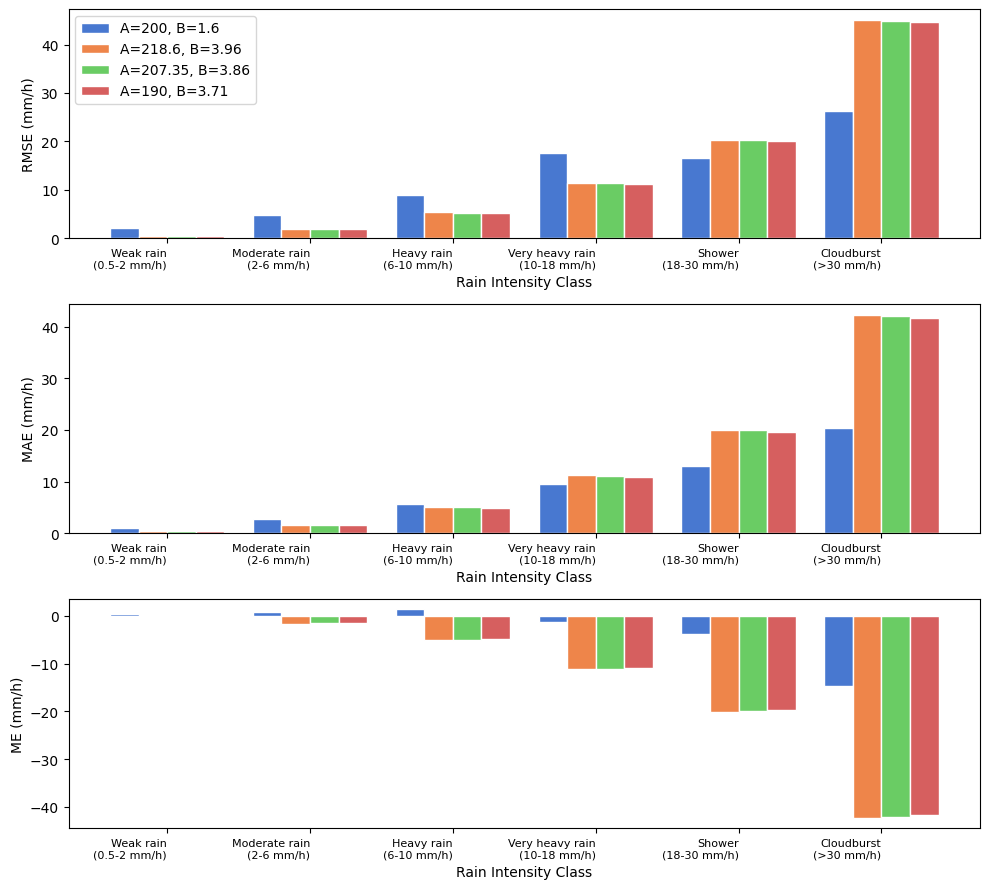

In [7]:
# Define the unique parameters and rain bins
parameters = error_df['Parameters'].unique()
rain_bins = error_df['Rain Bin'].unique()

# Set the width of the bars
bar_width = 0.2

# Set color palette
import seaborn as sns
colors = sns.color_palette("muted", len(parameters))

# Function to create the bar plots
def create_combined_bar_plots(metrics, titles, ylabels, filename):
    fig, axes = plt.subplots(3, 1, figsize=(10, 9))

    # Define the x positions for the groups
    x = np.arange(len(rain_bins))

    for idx, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        ax = axes[idx]
        for i, param in enumerate(parameters):
            subset = error_df[error_df['Parameters'] == param]
            values = subset[metric].values

            # Create bars for each parameter set
            ax.bar(x + i * bar_width, values, width=bar_width, label=param, color=colors[i], edgecolor = 'white')

        # Set labels and title
        ax.set_xlabel('Rain Intensity Class')
        ax.set_ylabel(ylabel)
        #ax.set_title(title)
        ax.set_xticks(x + bar_width * (len(parameters) - 1) / 2)
        ax.set_xticklabels(rain_bins, ha='right', size=8)
        if idx == 0:  # Only show legend on the first plot
            ax.legend()

    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.01, dpi=300)
    plt.show()

# Create combined bar plots for each metric
metrics = ['RMSE', 'MAE', 'ME']
titles = ['RMSE', 'MAE', 'ME']
ylabels = ['RMSE (mm/h)', 'MAE (mm/h)', 'ME (mm/h)']
filename = 'error_metrics_intensity_combined.png'

create_combined_bar_plots(metrics, titles, ylabels, filename)

## Error metrics aggregated

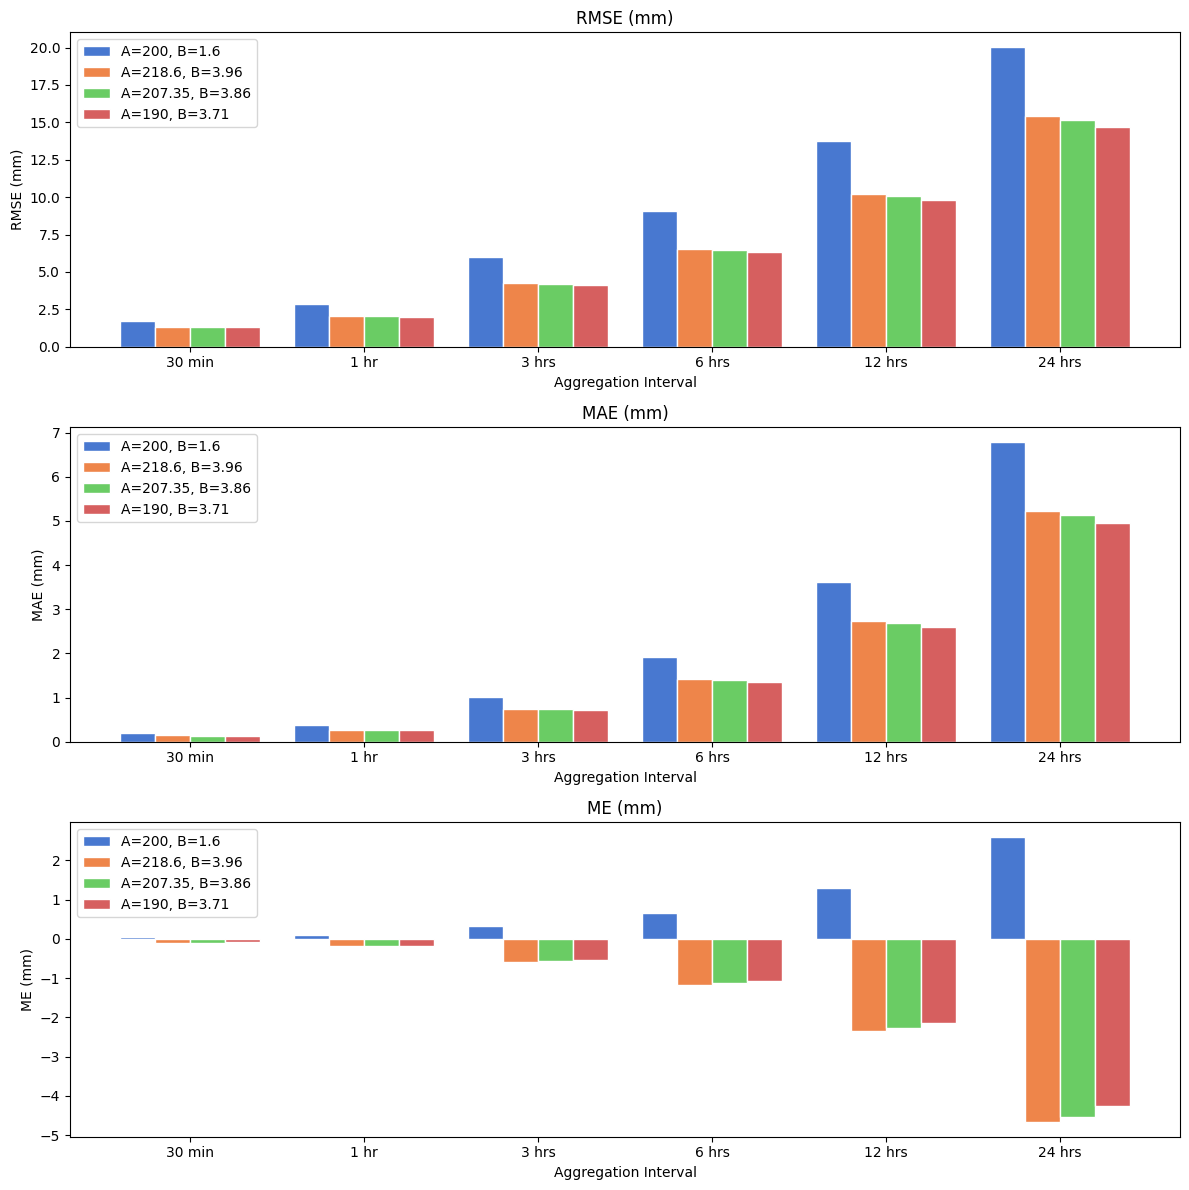

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

# Define RMSE, MAE, and ME functions using aliases
def rmse_metric(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))

def mae_metric(predictions, targets):
    return mean_absolute_error(targets, predictions)

def me_metric(predictions, targets):
    return np.mean(predictions - targets)

# Add predictions to df_test for each parameter combination
for i, (A, B) in enumerate(zip(A_est, B_est)):
    df_test[f'R_pred_{i}'] = pf.Z_to_R_marshall_palmer(df_test['Z'], A, B)

# Define aggregation intervals
intervals = ['30T', '60T', '180T', '360T', '720T', '1440T']  # Pandas resample intervals
interval_labels = ['30 min', '1 hr', '3 hrs', '6 hrs', '12 hrs', '24 hrs']

# Initialize storage for aggregated errors
aggregated_errors = []

# Compute aggregated errors for each parameter combination and interval
for i in range(len(A_est)):
    metrics = {}
    for interval in intervals:
        aggregated_errors_interval = {'RMSE': [], 'MAE': [], 'ME': []}
        for station_id, df_station in df_test.groupby('stationId'):
            df_station = df_station.set_index('timestamp')
            aggregated = df_station[[f'R_pred_{i}', 'R_mm_per_h']].resample(interval).sum()
            if len(aggregated) > 0:  # Ensure there is data after resampling
                aggregated_errors_interval['RMSE'].append(rmse_metric(aggregated[f'R_pred_{i}'], aggregated['R_mm_per_h']))
                aggregated_errors_interval['MAE'].append(mae_metric(aggregated[f'R_pred_{i}'], aggregated['R_mm_per_h']))
                aggregated_errors_interval['ME'].append(me_metric(aggregated[f'R_pred_{i}'], aggregated['R_mm_per_h']))
        
        metrics[f'RMSE_{interval}'] = np.mean(aggregated_errors_interval['RMSE'])
        metrics[f'MAE_{interval}'] = np.mean(aggregated_errors_interval['MAE'])
        metrics[f'ME_{interval}'] = np.mean(aggregated_errors_interval['ME'])
    
    aggregated_errors.append(metrics)
    
# Prepare data for plotting
bar_width = 0.2
x = np.arange(len(intervals))
colors = sns.color_palette("muted", len(A_est))

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# Titles and labels for the subplots
titles = ['RMSE (mm)', 'MAE (mm)', 'ME (mm)']
y_labels = ['RMSE (mm)', 'MAE (mm)', 'ME (mm)']

for i, (title, y_label) in enumerate(zip(titles, y_labels)):
    ax = axs[i]
    
    # Plotting each set of parameters
    for j, (A, B) in enumerate(zip(A_est, B_est)):
        metric = titles[i].split()[0]  # RMSE, MAE, or ME
        error_values = [aggregated_errors[j][f'{metric}_{interval}'] for interval in intervals]
        ax.bar(x + j * bar_width, error_values, width=bar_width, label=f'A={A}, B={B}', color=colors[j], edgecolor = 'white')
    
    # Setting x-axis labels and positions
    ax.set_xticks(x + bar_width * (len(A_est) - 1) / 2)
    ax.set_xticklabels(interval_labels)
    ax.set_xlabel('Aggregation Interval')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend(loc='upper left')
    #ax.grid(True)

plt.tight_layout()
plt.savefig('error_metrics_aggregation_intervals.png', format='png', dpi=300)
plt.show()

C:\Users\Henri\AppData\Local\Temp\ipykernel_18816\2388692394.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_filtered[f'R_pred_{A}_{B}'] = rain_rate[valid_idx]
C:\Users\Henri\AppData\Local\Temp\ipykernel_18816\2388692394.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_filtered[f'R_pred_{A}_{B}'] = rain_rate[valid_idx]
C:\Users\Henri\AppData\Local\Temp\ipykernel_18816\2388692394.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

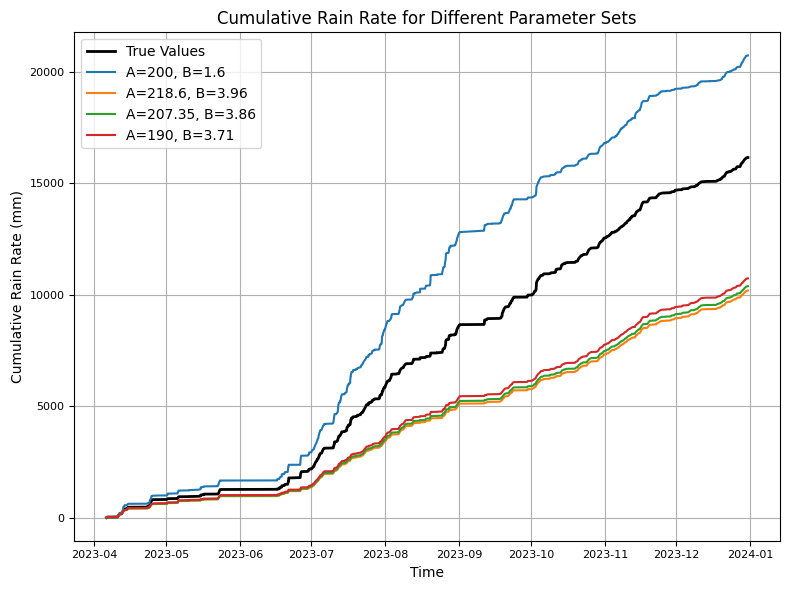

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data using valid_idx
df_test_filtered = df_test.loc[valid_idx]

# Select only numeric columns for grouping and averaging
numeric_cols = df_test_filtered.select_dtypes(include=[np.number]).columns

# Group by the timestamp and compute the mean for each group for numeric columns only
df_test_grouped = df_test_filtered[numeric_cols].groupby(df_test_filtered['timestamp']).mean()

# Compute cumulative sum of the true rain rates
cumulative_true_rain = np.cumsum(df_test_grouped['R_mm_per_h'])

# Compute cumulative sums of the rain rates
rain_rates_grouped = []
for rain_rate in rain_rates:
    # Add the rain rate predictions to the filtered DataFrame
    df_test_filtered[f'R_pred_{A}_{B}'] = rain_rate[valid_idx]
    # Group by timestamp and average the predictions
    df_grouped = df_test_filtered[[f'R_pred_{A}_{B}']].groupby(df_test_filtered['timestamp']).mean()
    # Compute cumulative sum of the grouped predictions
    rain_rates_grouped.append(np.cumsum(df_grouped[f'R_pred_{A}_{B}']))

# Plot cumulative rain rates
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(cumulative_true_rain.index, cumulative_true_rain, label='True Values', color='black', linewidth=2)

# Plot predicted values
for i, (A, B, cum_rain_rate) in enumerate(zip(A_est, B_est, rain_rates_grouped)):
    plt.plot(cumulative_true_rain.index, cum_rain_rate, label=f'A={A}, B={B}')

plt.xlabel('Time')
plt.ylabel('Cumulative Rain Rate (mm)')
plt.title('Cumulative Rain Rate for Different Parameter Sets')
plt.legend()
plt.grid(True)
plt.xticks(size = 8)
plt.yticks(size = 8)
plt.tight_layout()

plt.savefig('cumulative_rain_rates.png', format='png', dpi=300)
plt.show()


C:\Users\Henri\AppData\Local\Temp\ipykernel_18816\105895206.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_filtered[f'R_pred_{A}_{B}'] = rain_rate[valid_idx] / 12  # Convert to mm for 5-minute intervals
C:\Users\Henri\AppData\Local\Temp\ipykernel_18816\105895206.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_filtered[f'R_pred_{A}_{B}'] = rain_rate[valid_idx] / 12  # Convert to mm for 5-minute intervals
C:\Users\Henri\AppData\Local\Temp\ipykernel_18816\105895206.py:24: SettingWith

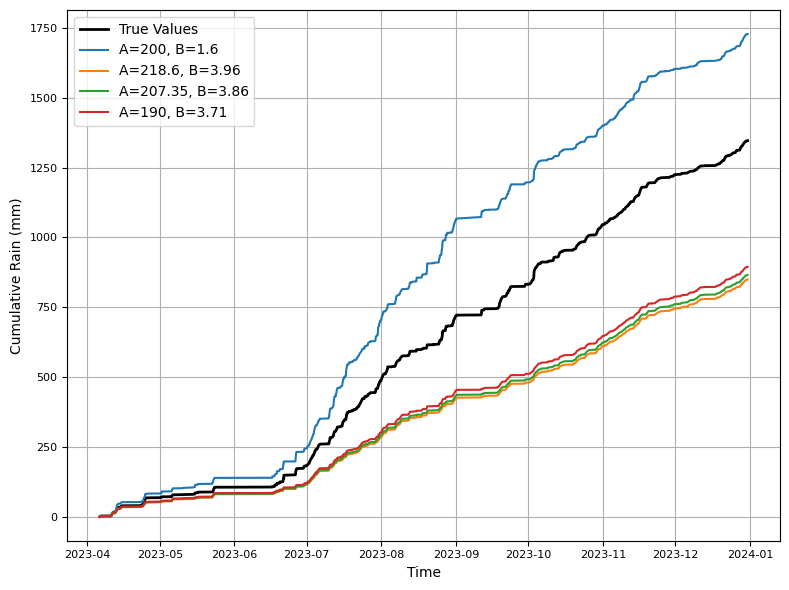

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data using valid_idx
df_test_filtered = df_test.loc[valid_idx]

# Select only numeric columns for grouping and averaging
numeric_cols = df_test_filtered.select_dtypes(include=[np.number]).columns

# Group by the timestamp and compute the mean for each group for numeric columns only
df_test_grouped = df_test_filtered[numeric_cols].groupby(df_test_filtered['timestamp']).mean()

# Convert rain rates from mm/h to mm for 5-minute intervals
df_test_grouped['R_mm'] = df_test_grouped['R_mm_per_h'] / 12 

# Compute cumulative sum of the true rain rates
cumulative_true_rain = np.cumsum(df_test_grouped['R_mm'])

# Compute cumulative sums of the rain rates
rain_rates_grouped = []
for rain_rate in rain_rates:
    # Add the rain rate predictions to the filtered DataFrame
    df_test_filtered[f'R_pred_{A}_{B}'] = rain_rate[valid_idx] / 12  # Convert to mm for 5-minute intervals
    # Group by timestamp and average the predictions
    df_grouped = df_test_filtered[[f'R_pred_{A}_{B}']].groupby(df_test_filtered['timestamp']).mean()
    # Compute cumulative sum of the grouped predictions
    rain_rates_grouped.append(np.cumsum(df_grouped[f'R_pred_{A}_{B}']))

# Plot cumulative rain rates
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(cumulative_true_rain.index, cumulative_true_rain, label='True Values', color='black', linewidth=2)

# Plot predicted values
for i, (A, B, cum_rain_rate) in enumerate(zip(A_est, B_est, rain_rates_grouped)):
    plt.plot(cumulative_true_rain.index, cum_rain_rate, label=f'A={A}, B={B}')

plt.xlabel('Time')
plt.ylabel('Cumulative Rain (mm)')
#plt.title('Cumulative Rain for Different Parameter Sets')
plt.legend()
plt.grid(True)
plt.xticks(size=8)
plt.yticks(size=8)
plt.tight_layout()

plt.savefig('cumulative_rain_rates.png', format='png', dpi=300)
plt.show()


In [11]:
df_test = pd.read_csv(base_path + f'/data/testZR_v3_31.csv')
df_test['R_mm_per_h'] = np.array(df_test['R'] * 60) # Convert mm/min to mm/h

# Remove nans
#df_test = df_test.dropna(subset=['dBZ', 'R', 'Z'])

# Convert timestamp to datetime and remove low quality observations
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test[df_test['timestamp'].dt.minute % 10 == 0]

# Valid evaluation idx for evaluation
valid_idx = (df_test['R'] * 60 > 0) & (df_test['Z'] > 0)  & ~df_test['R'].isnull() & ~df_test['Z'].isnull()

# Set invalid rows to zero
df_test.loc[~valid_idx, ['R', 'Z']] = 0

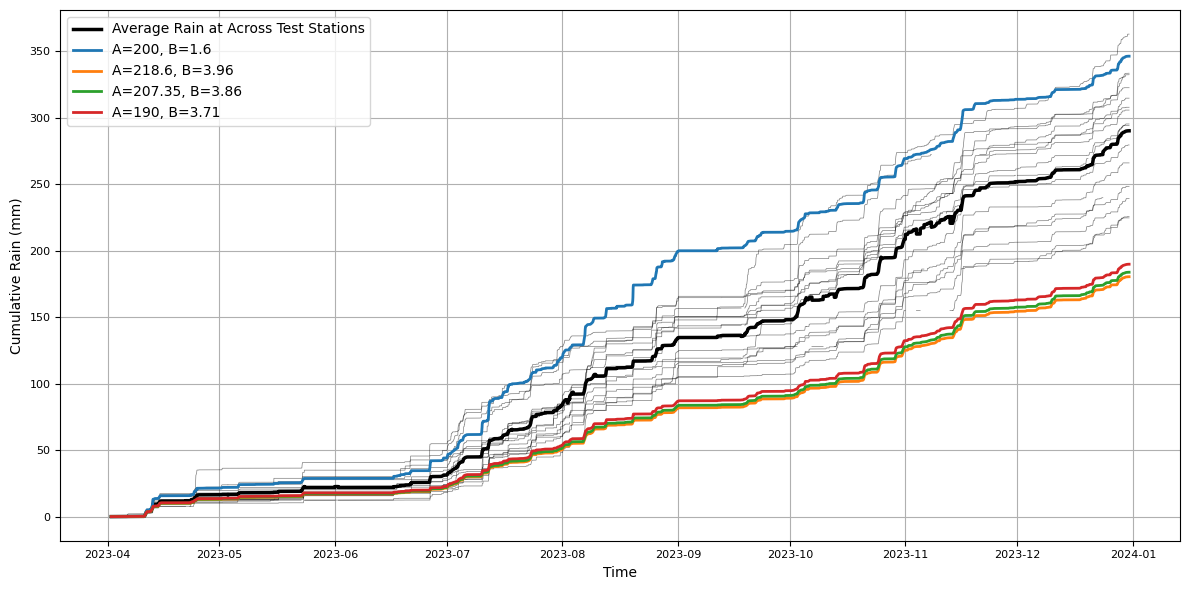

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def Z_to_R_marshall_palmer(Z, A=200, B=1.6):
    Z = np.asarray(Z)
    R = (Z / A)**(1/B)
    return R



# Filter the data using valid_idx
df_test_filtered = df_test

# Ensure 'timestamp' is in datetime format
df_test_filtered['timestamp'] = pd.to_datetime(df_test_filtered['timestamp'])

# Convert rain rates from mm/h to mm for 5-minute intervals
df_test_filtered['R_mm'] = df_test_filtered['R_mm_per_h'] / 12

# Group by 'stationId' and 'timestamp', then compute the mean for each group
df_test_grouped = df_test_filtered.groupby(['stationId', 'timestamp'])['R_mm'].mean().reset_index()

# Compute cumulative sum of the true rain rates for each stationId
# Assuming df_test_filtered and df_test_grouped are already created

# Dictionary to store cumulative sums for each station
cumulative_rain_per_station = {}
stations = df_test_grouped['stationId'].unique()

plt.figure(figsize=(12, 6))

for station in stations:
    df_subset = df_test_grouped[df_test_grouped['stationId'] == station].sort_values('timestamp')
    cumulative_rain_per_station[station] = np.cumsum(df_subset['R_mm']).values

# Create a DataFrame with cumulative sums for each station
cumulative_rain_df = pd.DataFrame(cumulative_rain_per_station)

# Add timestamps to the DataFrame
timestamps = df_test_grouped[df_test_grouped['stationId'] == stations[0]].sort_values('timestamp')['timestamp'].values
cumulative_rain_df['timestamp'] = timestamps

# Set 'timestamp' as the index
cumulative_rain_df.set_index('timestamp', inplace=True)

# Calculate the average cumulative rain and add it as a new column
cumulative_rain_df['average'] = cumulative_rain_df.mean(axis=1)

# Plot the cumulative rain for each station
for station in stations:
    df_subset = df_test_grouped[df_test_grouped['stationId'] == station].sort_values('timestamp')
    plt.plot(df_subset['timestamp'], cumulative_rain_per_station[station], lw=0.5, alpha=0.5, color='black')

# Plot the average cumulative rain
plt.plot(cumulative_rain_df.index, cumulative_rain_df['average'], color='black', linewidth=2.5, label='Average Rain at Across Test Stations')

# Model estimates
A_est = [200, 218.60, 207.35, 190]
B_est = [1.6, 3.96, 3.86, 3.71]

# Compute and plot average cumulative rain for each model
for i, (A, B) in enumerate(zip(A_est, B_est)):
    # Compute rain rates for each station
    rain_rates = Z_to_R_marshall_palmer(df_test['Z'], A, B)
    df_test['R_mm_model'] = rain_rates / 12  # Convert to mm for 5-minute intervals

    # Group by 'stationId' and 'timestamp', then compute the mean for each group
    df_test_grouped_model = df_test.groupby(['stationId', 'timestamp'])['R_mm_model'].mean().reset_index()

    # Compute cumulative sum for each station
    cumulative_rain_model_per_station = {}
    for station in stations:
        df_subset = df_test_grouped_model[df_test_grouped_model['stationId'] == station].sort_values('timestamp')
        cumulative_rain_model_per_station[station] = np.cumsum(df_subset['R_mm_model']).values

    # Create a DataFrame with cumulative sums for each station
    cumulative_rain_model_df = pd.DataFrame(cumulative_rain_model_per_station)

    # Add timestamps to the DataFrame
    cumulative_rain_model_df['timestamp'] = timestamps

    # Set 'timestamp' as the index
    cumulative_rain_model_df.set_index('timestamp', inplace=True)

    # Calculate the average cumulative rain and add it as a new column
    cumulative_rain_model_df['average'] = cumulative_rain_model_df.mean(axis=1)

    # Plot the average cumulative rain for the model
    plt.plot(cumulative_rain_model_df.index, cumulative_rain_model_df['average'], linewidth=2, label=f'A={A}, B={B}')

# Plot formatting
plt.xlabel('Time')
plt.ylabel('Cumulative Rain (mm)')
#plt.title('Cumulative Rain for Different Stations and Models')
plt.legend()
plt.grid(True)
plt.xticks(size=8)
plt.yticks(size=8)
plt.tight_layout()

plt.savefig('cumulative_rain_rates_models_average.png', format='png', dpi=300)
plt.show()
